In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pandas import Series
%matplotlib inline
import warnings
import seaborn as sns
warnings.filterwarnings("ignore")

In [2]:
train=pd.read_csv('Train_SU63ISt.csv')
test=pd.read_csv('Test_0qrQsBZ.csv')
train_copy=train.copy()
test_copy=test.copy()

In [3]:
train.head()

,ID,Datetime,Count
0,0,25-08-2012 00:00,8
1,1,25-08-2012 01:00,2
2,2,25-08-2012 02:00,6
3,3,25-08-2012 03:00,2
4,4,25-08-2012 04:00,2


In [4]:
#lest look at the data
train.dtypes ,test.dtypes

(ID           int64
 Datetime    object
 Count        int64
 dtype: object, ID           int64
 Datetime    object
 dtype: object)

In [5]:
train.shape , test.shape

((18288, 3), (5112, 2))

In [6]:
#convert to time
train['Datetime']=pd.to_datetime(train['Datetime'] , format='%d-%m-%Y %H:%M')
test['Datetime']=pd.to_datetime(test['Datetime'] , format='%d-%m-%Y %H:%M')
train_copy['Datetime']=pd.to_datetime(train_copy['Datetime'] , format='%d-%m-%Y %H:%M')
test_copy['Datetime']=pd.to_datetime(test_copy['Datetime'] , format='%d-%m-%Y %H:%M')


In [7]:
train.head()

,ID,Datetime,Count
0,0,2012-08-25 00:00:00,8
1,1,2012-08-25 01:00:00,2
2,2,2012-08-25 02:00:00,6
3,3,2012-08-25 03:00:00,2
4,4,2012-08-25 04:00:00,2


In [8]:
#lets get y,m,d from each datset
for i in (train,train_copy,test,test_copy):
    i['Year']=i['Datetime'].dt.year
    i['Month']=i['Datetime'].dt.month
    i['Day']=i['Datetime'].dt.day
    i['Hour']=i['Datetime'].dt.hour
    

In [9]:
#lets see the result
train.tail()

,ID,Datetime,Count,Year,Month,Day,Hour
18283,18283,2014-09-25 19:00:00,868,2014,9,25,19
18284,18284,2014-09-25 20:00:00,732,2014,9,25,20
18285,18285,2014-09-25 21:00:00,702,2014,9,25,21
18286,18286,2014-09-25 22:00:00,580,2014,9,25,22
18287,18287,2014-09-25 23:00:00,534,2014,9,25,23


### Lets see the effect of weekend on the traffic

In [10]:
train['weekday']=train['Datetime'].dt.dayofweek
train['weekend']=[1 if x in (5,6) else 0 for x in train['weekday']]

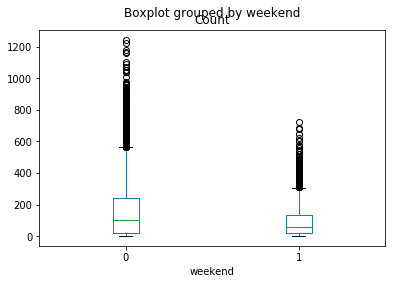

In [11]:
train.boxplot(by='weekend',column='Count',grid=False)

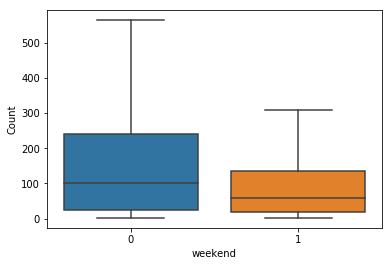

In [12]:
sns.boxplot(x='weekend',y='Count',data=train,showfliers=False)

## lets see the trend

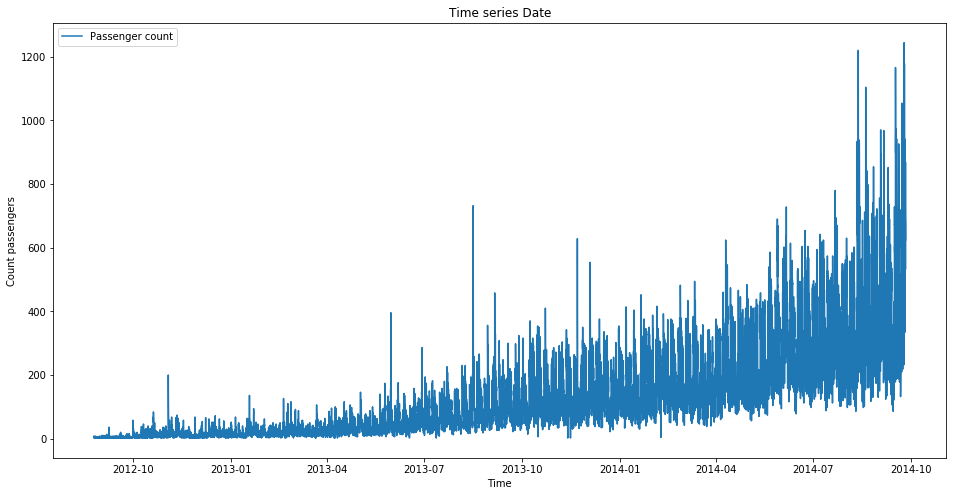

In [13]:
train.index=train['Datetime']
train.drop('ID',inplace=True,axis=1)
plt.figure(figsize=(16,8))
plt.plot(train['Count'],label='Passenger count')
plt.title('Time series Date')
plt.xlabel('Time')
plt.ylabel('Count passengers')
plt.legend(loc='best')
plt.show()

### List of Hypotesis:
### *Traffic will increase as the years pass by
###  *Traffic will be high from May to October
###  *Traffic on weekdays will be more
###  *Traffic during the peak hours will be high

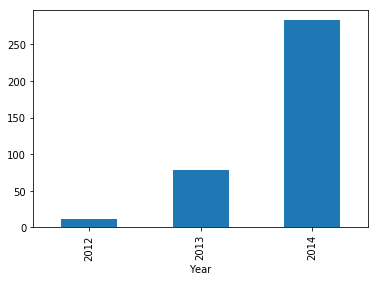

In [14]:
### *Traffic will increase as the years pass by
train.groupby('Year')['Count'].mean().plot.bar()


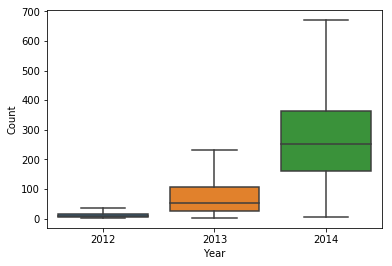

In [15]:
#more statistical compariosn!
sns.boxplot(x='Year' , y='Count' ,data=train,showfliers=False)

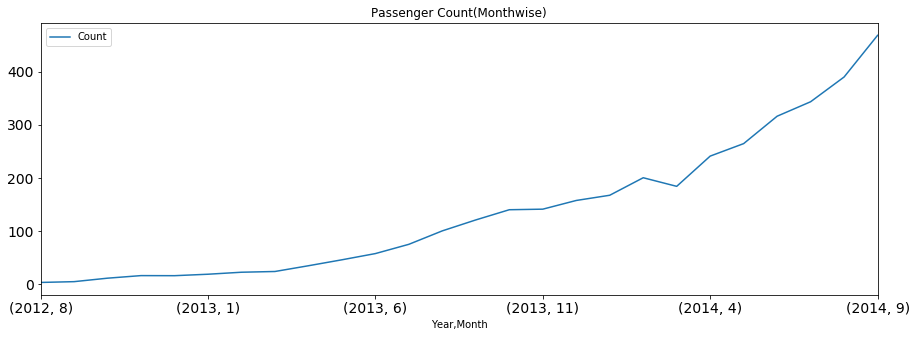

In [16]:
###  *Traffic will be high from May to October
#train.groupby('Month')['Count'].mean().plot.bar()
# this seems incorrect as the average previous years affects so:
temp=train.groupby(['Year','Month'])['Count'].mean()
temp=pd.DataFrame(temp)
temp.plot(figsize=(15,5), title= 'Passenger Count(Monthwise)', fontsize=14)

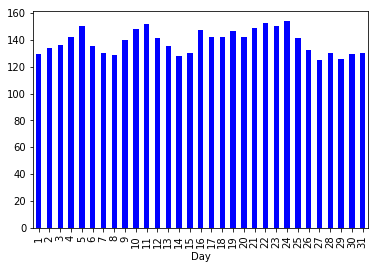

In [17]:
train.groupby('Day')['Count'].mean().plot.bar(color='b')

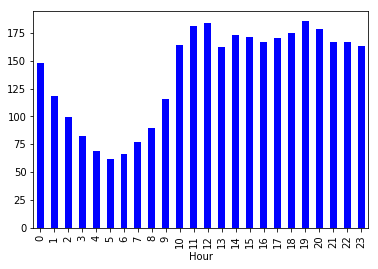

In [18]:
#it seems days do not have a good insight on the hypothesis so lets see Hours
train.groupby('Hour')['Count'].mean().plot.bar(color='b')

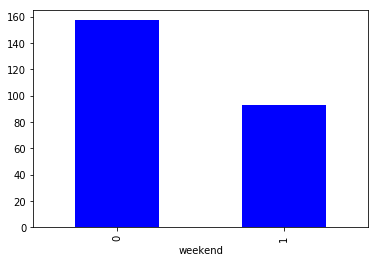

In [19]:
#lets see weekday affect on traffice
train.groupby('weekend')['Count'].mean().plot.bar(color='b')


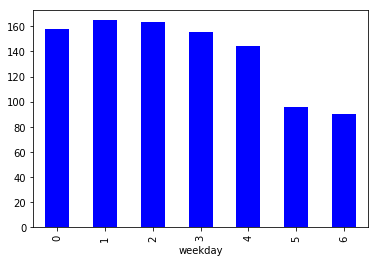

In [20]:
train.groupby('weekday')['Count'].mean().plot.bar(color='b')

In [21]:
# lets aggreagte times to bigger intervals to have a better insight
hourly=train.resample('H').mean()
Daily=train.resample('D').mean()
Weekly=train.resample('W').mean()
Montly=train.resample('M').mean()

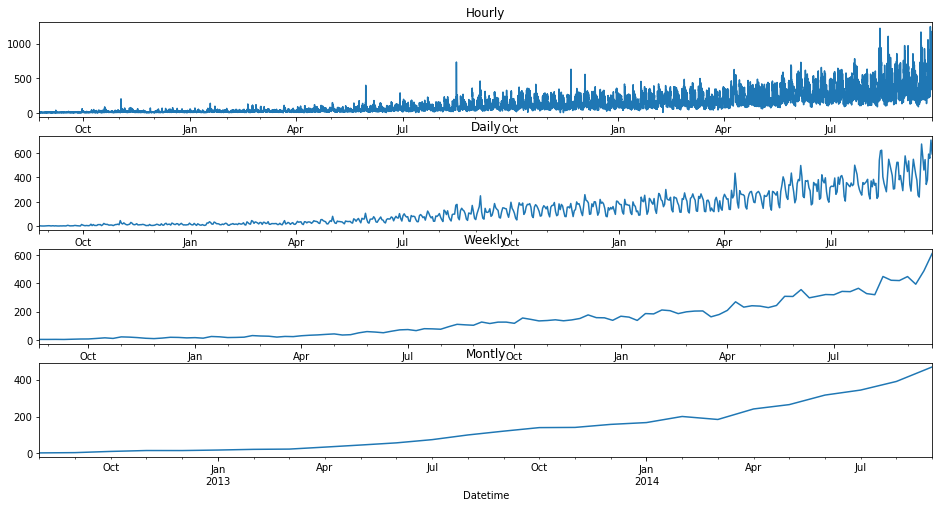

In [22]:
#lets visulaize them
fig ,axs=plt.subplots(4,1)
hourly.Count.plot(figsize=(16,8) ,title='Hourly',ax=axs[0])
Daily.Count.plot(figsize=(16,8) ,title='Daily',ax=axs[1])
Weekly.Count.plot(figsize=(16,8) ,title='Weekly',ax=axs[2])
Montly.Count.plot(figsize=(16,8) ,title='Montly',ax=axs[3])




In [23]:
test.Timestamp = pd.to_datetime(test.Datetime,format='%d-%m-%Y %H:%M') 
test.index = test.Timestamp  

# Converting to daily mean 
test = test.resample('D').mean()

#### lets create validation and Train set 
#### last 3 month will be in the validation because if we choose randomly in validation set it means predict old data based 
#### on future that is meaningless so for timebased dataset we use this 

In [24]:
Train=train.ix['2012-08-25':'2014-06-24']
Valid=train.ix['2014-06-25':'2014-09-25']


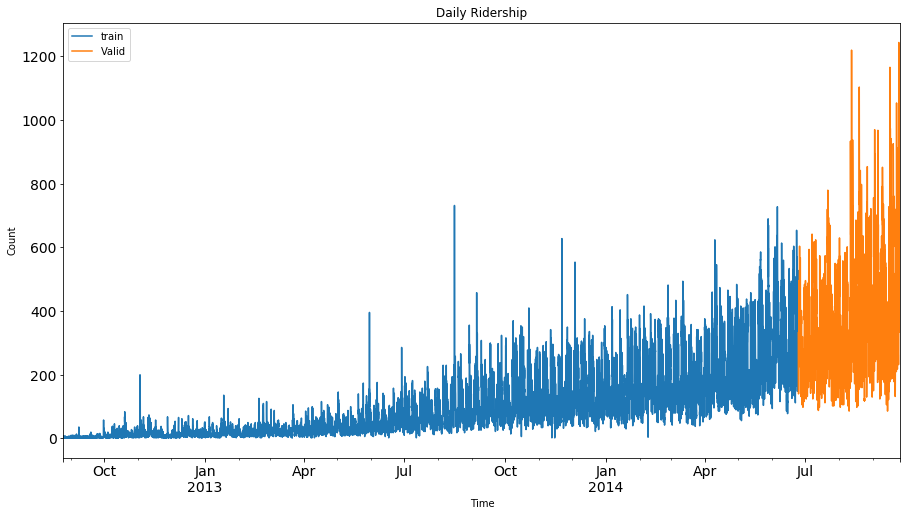

In [25]:
Train.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='train')
Valid.Count.plot(figsize=(15,8), title= 'Daily Ridership', fontsize=14, label='Valid')
plt.xlabel('Time')
plt.ylabel('Count')
plt.legend(loc='best')
plt.show()

## lets dive into the forecasting models
#### i) Naive Approach
#### ii) Moving Average
#### iii) Simple Exponential Smoothing
#### iv) Holt’s Linear Trend Model

In [26]:
#### i) Naive Approach
# put the latest count for other points
dd=np.asanyarray(Train.Count)
y_hat=Valid.copy()
y_hat['naive']=dd[len(dd)-1]

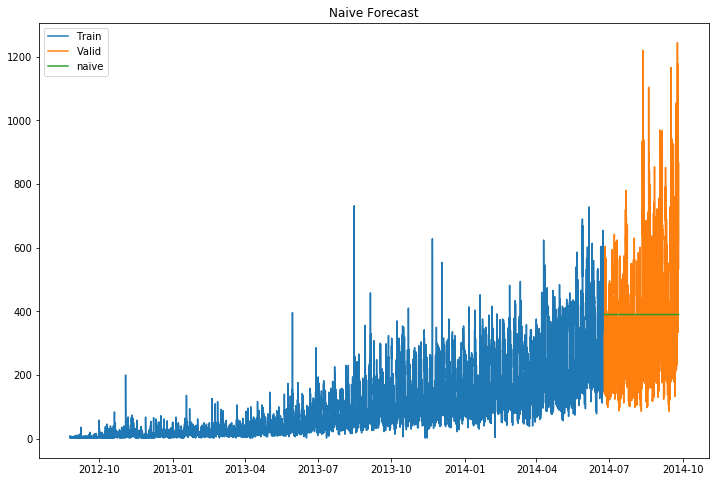

In [27]:
#lets visualize the data 
plt.figure(figsize=(12,8))
plt.plot(Train.index , Train.Count ,label='Train')
plt.plot(Valid.index , Valid.Count ,label='Valid')
plt.plot(y_hat.index , y_hat.naive ,label='naive')
plt.legend(loc='best') 
plt.title("Naive Forecast") 
plt.show()


In [28]:
Train.tail()

,Datetime,Count,Year,Month,Day,Hour,weekday,weekend
Datetime,,,,,,,,
2014-06-24 19:00:00,2014-06-24 19:00:00,398,2014,6,24,19,1,0
2014-06-24 20:00:00,2014-06-24 20:00:00,444,2014,6,24,20,1,0
2014-06-24 21:00:00,2014-06-24 21:00:00,406,2014,6,24,21,1,0
2014-06-24 22:00:00,2014-06-24 22:00:00,352,2014,6,24,22,1,0
2014-06-24 23:00:00,2014-06-24 23:00:00,390,2014,6,24,23,1,0


In [29]:
#lets calculate rsme
from sklearn.metrics import mean_squared_error
from math import sqrt
rsme=sqrt(mean_squared_error(y_hat.Count,y_hat.naive))
print(rsme)

186.37368520699056


#### ii) Moving Average


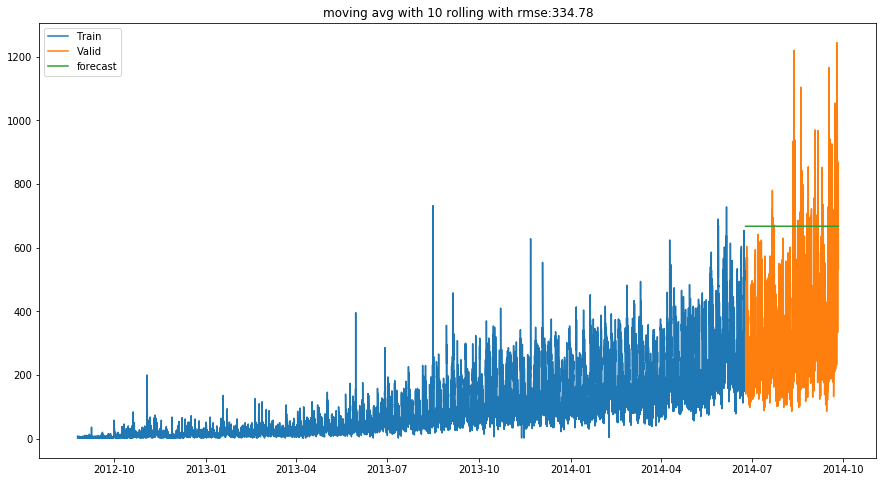

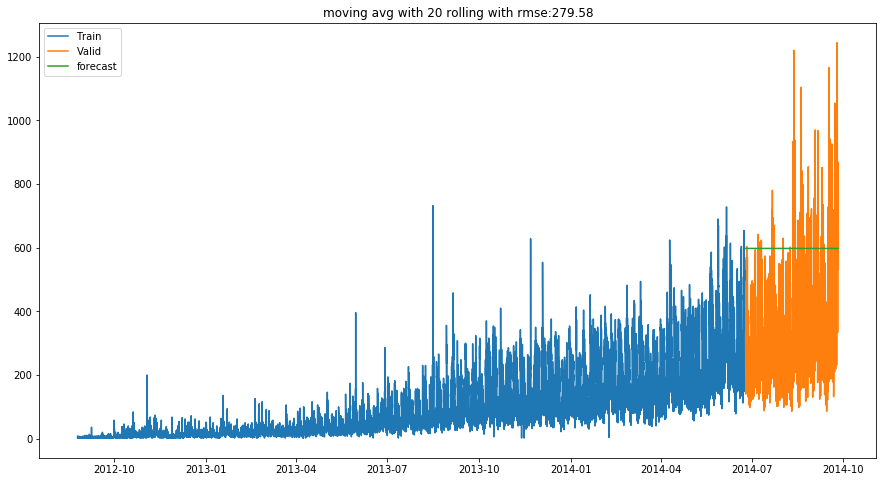

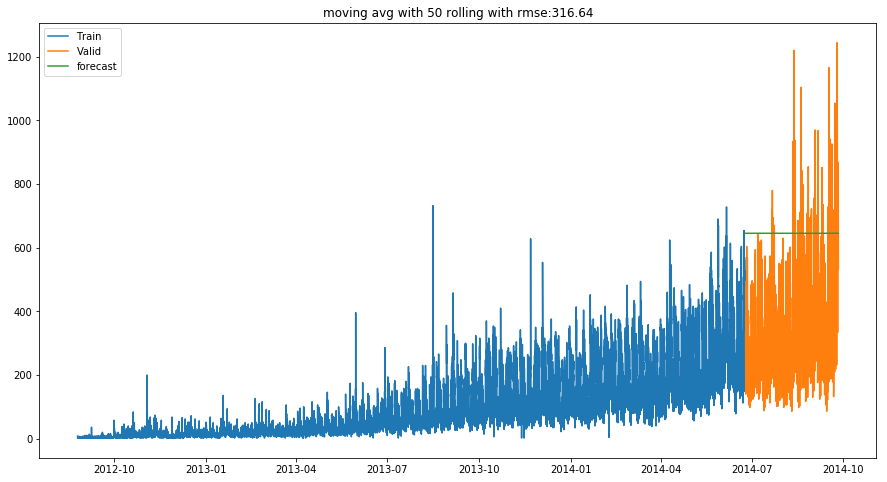

In [30]:
y_hat_avg=Valid.copy()
y_hat_avg['avg_forecast']=y_hat['Count'].rolling(10).mean().iloc[-1]
rmse=sqrt(mean_squared_error(y_hat.Count , y_hat_avg.avg_forecast))
plt.figure(figsize=(15,8))
plt.plot(Train.index,Train.Count,label='Train')
plt.plot(Valid.index,Valid.Count,label='Valid')
plt.plot(y_hat_avg.avg_forecast,label='forecast')
plt.legend(loc='Best')
plt.title('moving avg with 10 rolling with rmse:{}'.format(round(rmse,2)))
plt.show()


y_hat_avg=Valid.copy()
y_hat_avg['avg_forecast']=y_hat['Count'].rolling(20).mean().iloc[-1]
rmse=sqrt(mean_squared_error(y_hat.Count , y_hat_avg.avg_forecast))
plt.figure(figsize=(15,8))
plt.plot(Train.index,Train.Count,label='Train')
plt.plot(Valid.index,Valid.Count,label='Valid')
plt.plot(y_hat_avg.avg_forecast,label='forecast')
plt.legend(loc='Best')
plt.title('moving avg with 20 rolling with rmse:{}'.format(round(rmse,2)))
plt.show()


y_hat_avg=Valid.copy()
y_hat_avg['avg_forecast']=y_hat['Count'].rolling(50).mean().iloc[-1]
rmse=sqrt(mean_squared_error(y_hat.Count , y_hat_avg.avg_forecast))
plt.figure(figsize=(15,8))
plt.plot(Train.index,Train.Count,label='Train')
plt.plot(Valid.index,Valid.Count,label='Valid')
plt.plot(y_hat_avg.avg_forecast,label='forecast')
plt.legend(loc='Best')
plt.title('moving avg with 50 rolling with rmse:{}'.format(round(rmse,2)))
plt.show()

iii) Simple Exponential Smoothing¶


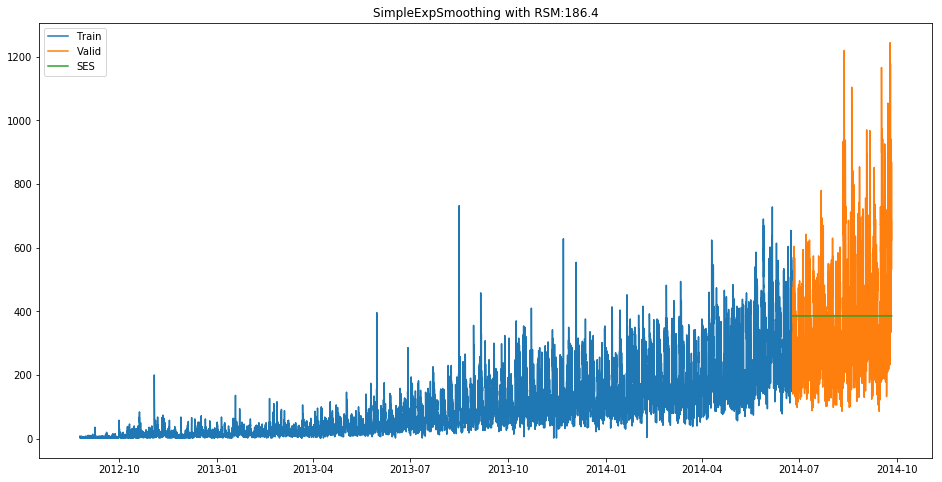

In [31]:
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
y_hat_avg=Valid.copy()
fit2=SimpleExpSmoothing(np.array(Train['Count'])).fit(smoothing_level=0.6,optimized=False)
y_hat_avg['SES']=fit2.forecast(len(Valid))
rmse=np.round(sqrt(mean_squared_error(Valid['Count'] , y_hat_avg['SES'])) ,1)

plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_avg['SES'], label='SES')
plt.title('SimpleExpSmoothing with RSM:{}'.format(rmse))
plt.legend(loc='Best')
plt.show()

iv) Holt’s Linear Trend Model

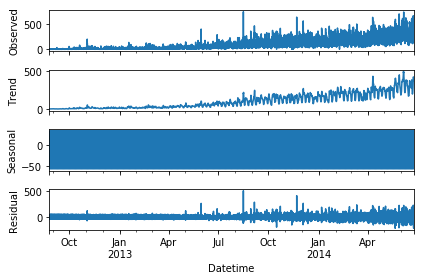

In [32]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(Train.Count).plot()
result=sm.tsa.adfuller(train.Count) 
plt.show()

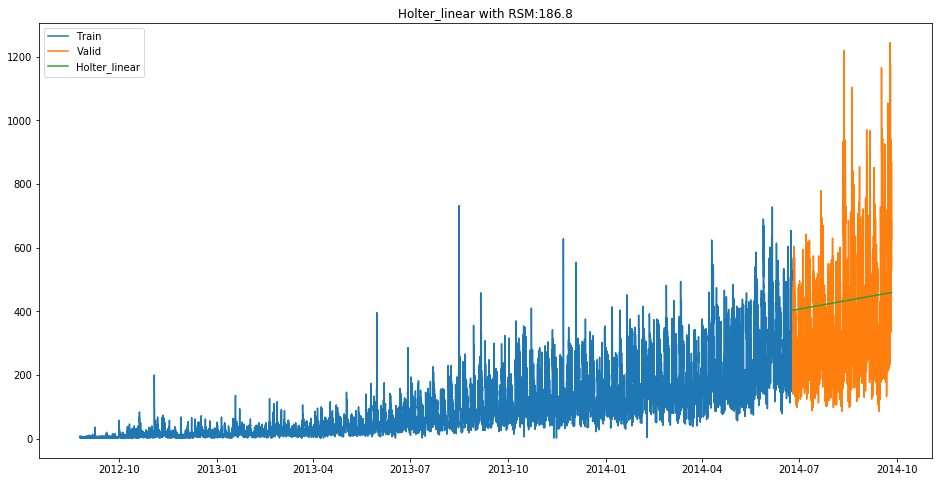

In [33]:
y_hat_avg=Valid.copy()
fit1=Holt(np.array(Train.Count)).fit(smoothing_level=0.3 )
y_hat_avg['Holter_linear']=fit1.forecast(len(Valid))

rmse=np.round(sqrt(mean_squared_error(Valid['Count'] , y_hat_avg['Holter_linear'])) ,1)

plt.figure(figsize=(16,8))
plt.plot(Train['Count'], label='Train')
plt.plot(Valid['Count'], label='Valid')
plt.plot(y_hat_avg['Holter_linear'], label='Holter_linear')
plt.title('Holter_linear with RSM:{}'.format(rmse))
plt.legend(loc='Best')
plt.show()

In [34]:
y_hat_avg.tail()

,Datetime,Count,Year,Month,Day,Hour,weekday,weekend,Holter_linear
Datetime,,,,,,,,,
2014-09-25 19:00:00,2014-09-25 19:00:00,868,2014,9,25,19,3,0,459.178588
2014-09-25 20:00:00,2014-09-25 20:00:00,732,2014,9,25,20,3,0,459.203602
2014-09-25 21:00:00,2014-09-25 21:00:00,702,2014,9,25,21,3,0,459.228616
2014-09-25 22:00:00,2014-09-25 22:00:00,580,2014,9,25,22,3,0,459.253630
2014-09-25 23:00:00,2014-09-25 23:00:00,534,2014,9,25,23,3,0,459.278644


In [35]:
submission=pd.read_csv('Sample_Submission_QChS6c3.csv')

#lets predict on test data set
predict=fit1.forecast(len(test))
test['prediction']=predict

In [36]:
#calculate the ratio of passenger count for each hour of every day
train_copy['ratio']=train_copy['Count']/train_copy['Count'].sum()
train_copy.head()

,ID,Datetime,Count,Year,Month,Day,Hour,ratio
0,0,2012-08-25 00:00:00,8,2012,8,25,0,3.148037e-06
1,1,2012-08-25 01:00:00,2,2012,8,25,1,7.870093e-07
2,2,2012-08-25 02:00:00,6,2012,8,25,2,2.361028e-06
3,3,2012-08-25 03:00:00,2,2012,8,25,3,7.870093e-07
4,4,2012-08-25 04:00:00,2,2012,8,25,4,7.870093e-07


In [37]:
#the average ratio of passenger count for every hour and we will get 24 ratios
temp=train_copy.groupby('Hour')['ratio'].sum()
temp.head()
# Groupby to csv format 
pd.DataFrame(temp,columns=['Hour','ratio']).to_csv('Groupby.csv')
temp2=pd.read_csv('Groupby.csv')
temp2.drop('Hour.1',1, inplace=True)
temp2.head()


,Hour,ratio
0,0,0.044287
1,1,0.035343
2,2,0.029911
3,3,0.024714
4,4,0.020802


In [38]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test,test_copy,on=('Day','Month','Year'),how='left')
merge['Hour']=merge['Hour_y']
merge.drop(['Year','Month','Datetime','Hour_x','Hour_y'],axis=1,inplace=True)
merge.head()

,ID_x,Day,prediction,ID_y,Hour
0,18299.5,26.0,403.472132,18288,0
1,18299.5,26.0,403.472132,18289,1
2,18299.5,26.0,403.472132,18290,2
3,18299.5,26.0,403.472132,18291,3
4,18299.5,26.0,403.472132,18292,4


In [39]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge,temp2,on='Hour',how='left')
prediction.head()

,ID_x,Day,prediction,ID_y,Hour,ratio
0,18299.5,26.0,403.472132,18288,0,0.044287
1,18299.5,26.0,403.472132,18289,1,0.035343
2,18299.5,26.0,403.472132,18290,2,0.029911
3,18299.5,26.0,403.472132,18291,3,0.024714
4,18299.5,26.0,403.472132,18292,4,0.020802


In [40]:
# Converting the ratio to the original scale
prediction['count']=prediction['prediction'] * prediction['ratio']*24
prediction['ID']=prediction['ID_y']
prediction.drop(['ID_x','Day','prediction','ratio','Hour','ID_y'], axis=1, inplace=True)
prediction.head()

,count,ID
0,428.841697,18288
1,342.238110,18289
2,289.638853,18290
3,239.318237,18291
4,201.434883,18292


In [41]:
# upload data 
prediction.to_csv('Holter_linear.csv',columns=['ID','count'],index=False)
# Got 640 rms in leader board 

In [42]:
prediction.head()

,count,ID
0,428.841697,18288
1,342.238110,18289
2,289.638853,18290
3,239.318237,18291
4,201.434883,18292


 4) Holt winter’s model on daily time series

In [43]:
y_hat_avg=Valid.copy()
fit1=ExponentialSmoothing(np.array(Train['Count']),seasonal_periods=7 , trend='add' , seasonal='add').fit()
y_hat_avg['Holter_Winter'] = fit1.forecast(len(Valid))
rmse=np.round(sqrt(mean_squared_error(Valid['Count'] , y_hat_avg['Holter_Winter'])) ,1)

plt.figure(figsize=(16,8))
plt.plot(Train['Count']  ,label='Train')
plt.plot(Valid['Count']  ,label='Valid')
plt.plot(y_hat_avg['Holter_Winter']  ,label='Holter_Winter')
plt.title('Holt_Winter with rmse:'.format(rmse))
plt.legend(loc='Best')
plt.show()

KeyboardInterrupt: 

 Expand to the test dataset

In [ ]:
predict=fit1.forecast(len(test))
test['prediction']=predict

In [ ]:
test.head()

In [ ]:
# Merge Test and test_original on day, month and year 
merge=pd.merge(test,test_copy,on=('Day','Month','Year'),how='left')
merge.head()

In [ ]:
merge['Hour']=merge['Hour_y']
merge.drop(['Year', 'Month', 'Datetime','Hour_x','Hour_y'], axis=1,inplace=True)
merge.head()

In [ ]:
# Predicting by merging merge and temp2 
prediction=pd.merge(merge, temp2, on='Hour', how='left')
prediction['Count']=prediction['prediction'] * prediction['ratio'] * 24
prediction.head()

In [ ]:
prediction['ID']=prediction['ID_y']
submission=prediction.drop(['Day','Hour','ratio','prediction', 'ID_x', 'ID_y'],axis=1)
submission.head()

In [57]:
pd.DataFrame(submission, columns=['ID','Count']).to_csv('Holt winters.csv',index=False)